<a href="https://colab.research.google.com/github/Suryaanugrah2001/EDA-Analisis-Sentimen-Aplikasi-Threads/blob/main/Analisis_Sentimen_Aplikasi_Threads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('fivethirtyeight')

In [35]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [36]:
from google.colab import files
df = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/threads_reviews.csv")
df.head()

,source,review_description,rating,review_date
0,Google Play,Very good app for Android phone and me,5,27-08-2023 10:31
1,Google Play,Sl👍👍👍👍,5,27-08-2023 10:28
2,Google Play,Best app,5,27-08-2023 9:47
3,Google Play,Gatiya app,1,27-08-2023 9:13
4,Google Play,Lit bruv,5,27-08-2023 9:00


In [37]:
df.shape

(40435, 4)

In [38]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [39]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

# run polarity_scores on the entire dataset
result = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['review_description']
    index = row['review_date']
    result[index] = sia.polarity_scores(text)

  0%|          | 0/40435 [00:00<?, ?it/s]

In [40]:
# menggabungkan
vaders = pd.DataFrame(result).T
vaders = vaders.reset_index().rename(columns={'index' : 'review_date'})
vaders = vaders.merge(df, how='right')

In [41]:
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

In [42]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
# Membersihkan deskripsi ulasan dan membuat korpus

corpus = []
for i in range(len(vaders)):
    review = re.sub(pattern='[^a-zA-Z]', repl='', string=vaders['review_description'][i])
    review = review.lower()

    review_word = review.split()
    review_word = [word for word in review_word if not word in set(stopwords.words('english'))]

    porstem = PorterStemmer()
    review = [porstem.stem(word) for word in review_word]
    review = ''.join(review)
    corpus.append(review)

In [44]:
# membuat fungsi untuk mengklasifikasikan sentimen menjadi positif, netral, dan negatif
def sentiment(compound_score):
    if compound_score >= 0.05:
        return 'positif'
    elif compound_score > -0.05 and compound_score < 0.05:
        return 'netral'
    else:
        return 'negatif'

vaders['sentiment'] = vaders.compound.apply(sentiment)

In [45]:
# mempersiapkan kata referensi Twitter untuk di analisis
twitter_refs = ['Twitter', 'Tweet', 'Elon Musk', 'Elon', 'Musk']

def identify_words(text, refs):
    flag = 0
    for ref in refs:
        if text.find(ref) !=-1:
            flag=1
            break
    return flag

vaders['twitter'] = vaders['review_description'].apply(lambda x: identify_words(x, twitter_refs))

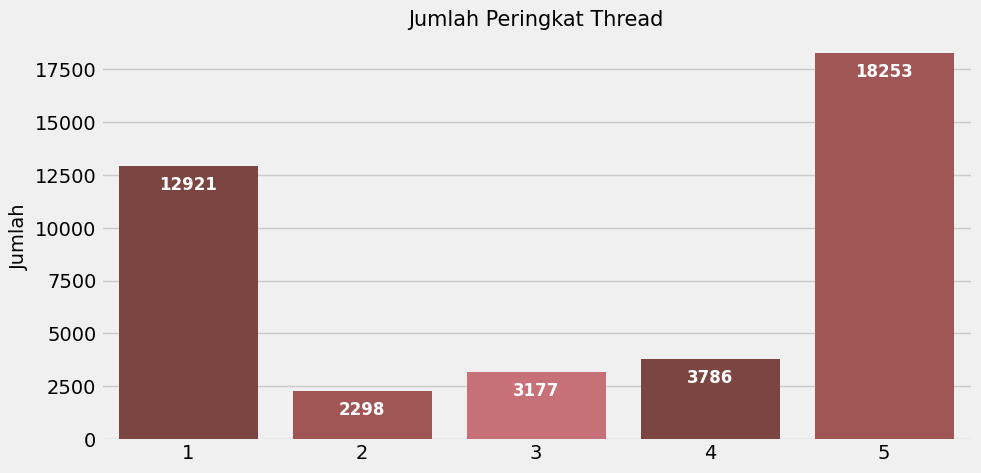

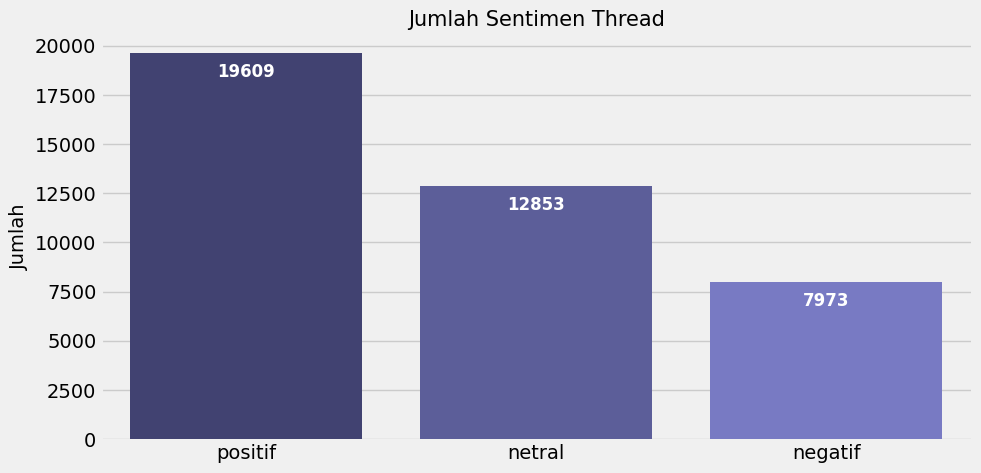

In [46]:
# Threads' Rating Counts
rating = vaders.groupby('rating').size().reset_index(name='count')
rating_count = rating.sort_values(by='count', ascending=False)

fig = plt.figure(figsize = (10,5))
color = sns.color_palette('tab20b')[12:15]
ax = sns.barplot(data=rating_count, y='count', x='rating', palette=color)

for i in ax.containers:
    ax.bar_label(i, padding=-20, color='white',
             fontsize=12, label_type='edge',
            fontweight='bold')

plt.xlabel('Rating', size=14)
plt.ylabel('Jumlah', size=14)
plt.title("Jumlah Peringkat Thread", size=15)

ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_xlabel('')
plt.show()

# Threads' Sentiment Counts
sentiment = vaders.groupby('sentiment').size().reset_index(name='count')
sentiment_count = sentiment.sort_values(by='count', ascending=False)

fig = plt.figure(figsize = (10,5))
color = sns.color_palette('tab20b')
ax = sns.barplot(data=sentiment_count, y='count', x='sentiment', palette=color)

for i in ax.containers:
    ax.bar_label(i, padding=-20, color='white',
             fontsize=12, label_type='edge',
            fontweight='bold')

plt.xlabel('Sentimen', size=14)
plt.ylabel('Jumlah', size=14)
plt.title("Jumlah Sentimen Thread", size=15)

ax.spines[['right', 'top', 'bottom']].set_visible(False)
ax.set_xlabel('')
plt.show()



*   Dapat dilihat dari histogram diatas, dapat diperhatikan hasil yang sangat kontradiktif antara sistem penilaian dan sistem sentimen. Penilaian 5 bintang mendominasi, diasumsikan sebagai skor positif dari pengguna, sementara penilaian 1 bintang menduduki posisi kedua yang menunjukkan skor negatif. Namun, jumlah sentimen menghasilkan hasil yang berbeda, di mana sentimen positif menduduki posisi pertama dan sentimen negatif di posisi terakhir.

*   Dalam konteks ulasan konsumen, penilaian bintang umumnya digunakan untuk memberikan indikasi cepat tentang sentimen ulasan, dan oleh karena itu merupakan alat bantu keputusan standar yang menyertai ulasan. Namun, penilaian bintang memiliki beberapa keterbatasan. Dalam banyak kasus, mereka bersifat bias (Qiu et al., 2012). Dalam kasus lain, penilaian bintang dan sentimen ulasan tidak cocok (Zhang et al., 2011), seperti kasus di mana skor bintang tinggi tetapi ulasan negatif, atau ketika skor bintang rendah tetapi ulasan positif. Oleh karena itu, saat menganalisis ulasan, Valdivia et al. (2017) menyarankan "... untuk tidak menetapkan tingkat pengguna sebagai sentimen label untuk seluruh ulasan dan menganalisis pendapat secara mendalam."



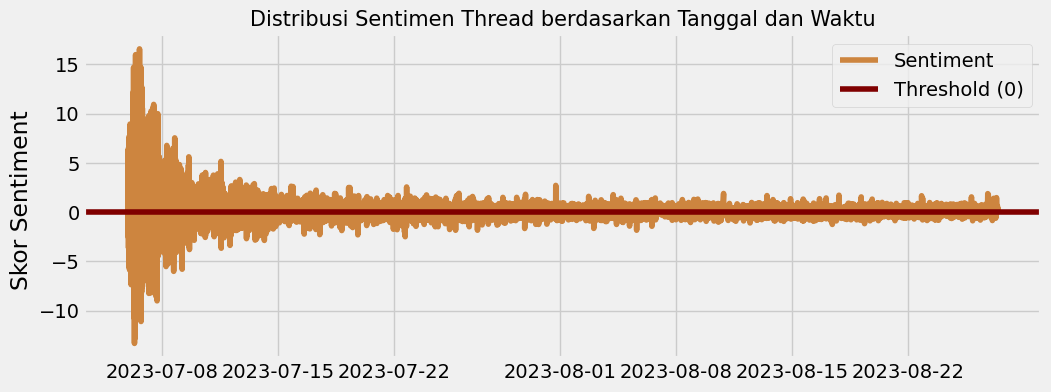

In [47]:
vaders['review_date'] = pd.to_datetime(vaders['review_date'], dayfirst=True)

reviewbydate = vaders.groupby('review_date')['compound'].sum()

threshold = 0
plt.figure(figsize=(11, 4))
plt.plot(reviewbydate.index, reviewbydate.values, label='Sentiment', color='peru')
plt.axhline(y=threshold, color='maroon', linestyle='solid', label=f'Threshold ({threshold})')
plt.title("Distribusi Sentimen Thread berdasarkan Tanggal dan Waktu", size=15)
plt.xlabel('')
plt.ylabel('Skor Sentiment ')
plt.legend()
plt.grid(True)
plt.show()

Dalam minggu pertama setelah peluncuran, banyak pengguna meninggalkan ulasan tentang aplikasi tersebut, baik yang positif Alpha(> 0,05) maupun negatif Alpha(< -0,05). Namun, secara bertahap, pengguna memberikan ulasan yang lebih sedikit. Antusiasme seputar aplikasi Threads nampaknya perlahan-lahan meredup, seperti yang dapat kita lihat dalam waktu hanya beberapa hari, mulai dari tanggal 8 hingga 22 menunjukkan penurunan besar.

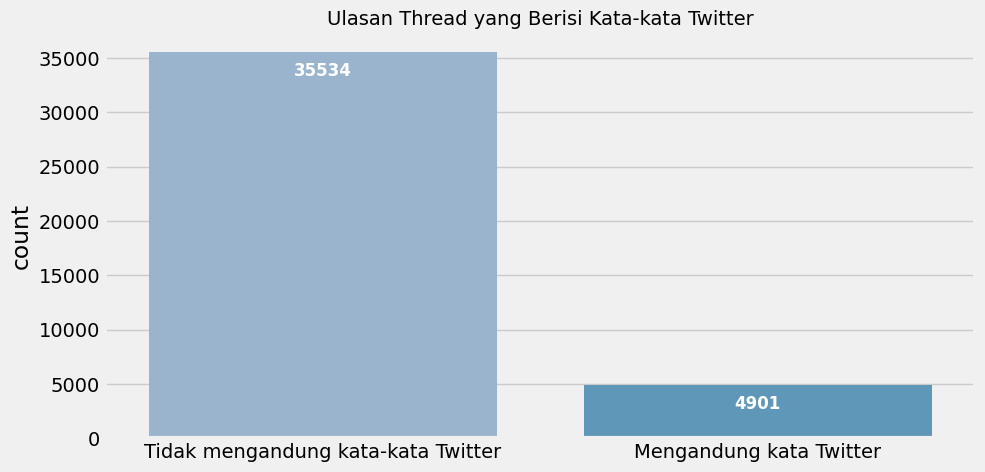

In [48]:
tweets = vaders.groupby('twitter').size().reset_index(name='count')
twitter_words = tweets.sort_values(by='count', ascending=False)

fig = plt.figure(figsize = (10,5))
color = sns.color_palette('PuBu')[2:6]
ax = sns.barplot(twitter_words, y='count', x='twitter', palette=color)

for i in ax.containers:
    ax.bar_label(i, padding=-20, color='white',
             fontsize=12, label_type='edge',
            fontweight='bold')

plt.title("Ulasan Thread yang Berisi Kata-kata Twitter", size=14)
ax.set_xticklabels(['Tidak mengandung kata-kata Twitter', 'Mengandung kata Twitter'])
ax.set_xlabel('')
plt.show()


Peluncuran aplikasi Threads ini membuat banyak pengguna yang membandingkan kedua platform tersebut, karena keduanya hampir memiliki fitur yang sama.
Menariknya, ada 4.901 pengguna yang telah meninggalkan ulasan yang mengandung kata yang terkait dengan Twitter. Para pengguna ini entah sedang membela atau mengkritik Twitter dalam perbandingan dengan Threads. Pihak mana yang Anda dukung?

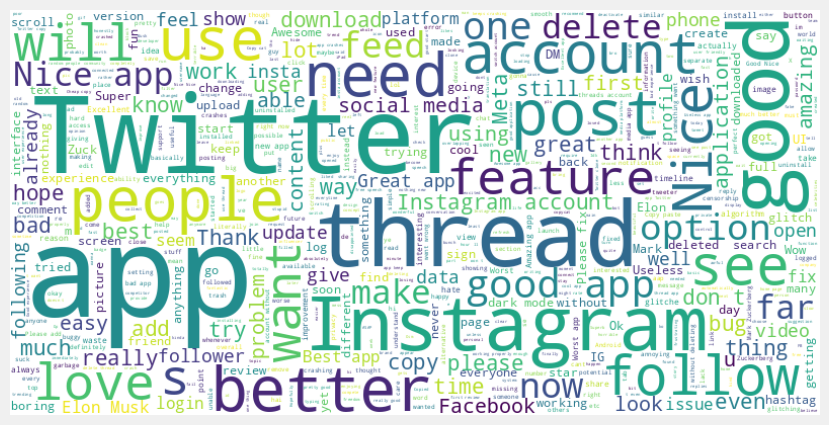

In [49]:
from wordcloud import WordCloud

word = ' '.join(vaders['review_description'])
word_cloud = WordCloud(width=800,
                          height=400,
                          max_words=1000,
                          background_color='white').generate(word)

plt.figure(figsize=(10,5))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Lebih banyak kata-kata yang bersifat positif muncul, seperti: "lebih baik", "bagus", "hebat", dan "cinta". Beberapa kata-kata negatif juga muncul, seperti: "buruk", "membosankan", "terburuk", dan "mengerikan".

Seperti yang diharapkan, Twitter telah menjadi topik yang menonjol dalam ulasan aplikasi Threads.Banyak pengguna membandingkan kedua platform ini karena fitur-fitur yang mereka miliki hampir serupa.

In [51]:
print("Semoga Bermanfaat")

Semoga Bermanfaat
